# Shuffle-based Dimensional Importance (SDI) 기법 개발을 위한 실험 코드입니다.

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


데이터셋 만들기 (Bands, Time, Height, Width)구조이다.

In [127]:
# 데이터 파라미터
num_samples = 10000  # 샘플 수
time_steps = 12     # 시간 차원
bands = 4          # 스펙트럼 밴드
height = 5         # 이미지 높이
width = 5          # 이미지 너비

material = torch.stack([
    torch.full((bands, height, width), random.choice(values).item())
    for _ in range(num_samples)
])

#dim_2의 규칙 부여
for t in range(time_steps):
    X_class0[:, :, t, :, :] = material * (t - 6) ** 2
    X_class3[:, :, t, :, :] = material * (t - 6) ** 2

    X_class1[:, :, t, :, :] = material * (-1) ** t
    X_class4[:, :, t, :, :] = material * (-1) ** t

    X_class2[:, :, t, :, :] = material * (t - 6) ** 3

#dim_1의 규칙 부여
X_class3[:, 0, :, :, :] = 0

#dim_3의 규칙 부여
X_class4[:, :, :, 0, :] = 0


# 레이블 할당
y_class0 = np.zeros(num_samples)
y_class1 = np.ones(num_samples)
y_class2 = np.full(num_samples, 2)
y_class3 = np.full(num_samples, 3) # time, band 중요
y_class4 = np.full(num_samples, 4) # time, width 중요

# 데이터 병합
X = np.concatenate([X_class0, X_class1, X_class2, X_class3, X_class4], axis=0)  # (Samples * 3, Bands, Time, Height, Width)
y = np.concatenate([y_class0, y_class1, y_class2, y_class3, y_class4], axis=0)  # (Samples * 3,)

# PyTorch Tensor 변환
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

print("데이터 Shape:", X.shape)  # (300, 4, 12, 5, 5)
print("레이블 Shape:", y.shape)  # (300,)

batch_size = 16

# 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True)

데이터 Shape: torch.Size([50000, 4, 12, 5, 5])
레이블 Shape: torch.Size([50000])


간단한 모델 정의(ResNet-like 구조의 2+1D CNN 모델을 사용합니다.)

In [128]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedVideoClassifier(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super().__init__()
        # Feature Extraction Block 1
        self.block1 = nn.Sequential(
            nn.Conv3d(4, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2), stride=(1,2,2))
        )

        # Feature Extraction Block 2 with Residual Connection
        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2))
        )

        # Feature Extraction Block 3
        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1,1,1))
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob/2),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)  # [B, 32, T, H/2, W/2]
        x = self.block2(x)  # [B, 64, T/2, H/4, W/4]
        x = self.block3(x)  # [B, 128, 1, 1, 1]
        x = x.view(x.size(0), -1)
        return self.classifier(x)

num_classes = 5
model = EnhancedVideoClassifier(num_classes)
model.to(device)


EnhancedVideoClassifier(
  (block1): Sequential(
    (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=

모델 학습

In [129]:
# 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0  # 맞힌 개수
    total = 0    # 전체 개수

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float()  # float64 → float32 변환
        y_batch = y_batch.long()   # 정수형 변환 (필요 시)

        optimizer.zero_grad()
        logits = model(X_batch)  # Forward pass
        loss = criterion(logits, y_batch)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        total_loss += loss.item()

        # 🔹 정확도 계산
        preds = torch.argmax(logits, dim=1)  # 가장 높은 확률의 클래스 선택
        correct += preds.eq(y_batch).sum().item()  # 맞힌 개수 누적
        total += y_batch.size(0)  # 전체 샘플 개수 누적

    # 🔹 평균 Loss 및 Accuracy 출력
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100  # 퍼센트(%)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/10, Loss: 0.1456, Accuracy: 93.37%
Epoch 2/10, Loss: 0.0398, Accuracy: 98.57%
Epoch 3/10, Loss: 0.0301, Accuracy: 98.88%
Epoch 4/10, Loss: 0.0288, Accuracy: 98.91%
Epoch 5/10, Loss: 0.0268, Accuracy: 98.96%
Epoch 6/10, Loss: 0.0231, Accuracy: 99.06%
Epoch 7/10, Loss: 0.0221, Accuracy: 99.07%
Epoch 8/10, Loss: 0.0220, Accuracy: 99.06%
Epoch 9/10, Loss: 0.0214, Accuracy: 99.11%
Epoch 10/10, Loss: 0.0197, Accuracy: 99.11%


잘 학습이 되었다.

# Shuffle-based Dimensional Importance (SDI)

In [130]:
import torch
import torch.nn.functional as F
import random

def sdi_importance_analysis(model, data_loader, num_samples=1, perturbation_strength=0.2):
    model.eval()

    sample_batch, _ = next(iter(data_loader))
    num_dims = len(sample_batch.shape) - 1
    dim_names = [f"dim_{i}" for i in range(1, num_dims + 1)]

    importance_scores = {dim: 0.0 for dim in dim_names}
    per_class_scores = {}

    num_batches = 0
    for X_batch, _ in data_loader:
        num_batches += 1
        X_batch = X_batch.to(next(model.parameters()).device)

        logit_original = model(X_batch).detach()
        num_classes = logit_original.shape[1]

        if not per_class_scores:
            per_class_scores = {cls: {dim: 0.0 for dim in dim_names} for cls in range(num_classes)}

        for dim_idx, dim_name in enumerate(dim_names, start=1):
            total_mse = 0.0
            class_mse = {cls: 0.0 for cls in range(num_classes)}

            for _ in range(num_samples):
                X_perturbed = X_batch.clone().detach()
                num_swap = max(1, int(X_perturbed.shape[dim_idx] * perturbation_strength))
                swap_indices = random.sample(range(X_perturbed.shape[dim_idx]), num_swap)
                permutation = random.sample(swap_indices, len(swap_indices))

                X_perturbed.index_copy_(dim_idx, torch.tensor(swap_indices, device=X_batch.device),
                                        X_perturbed.index_select(dim_idx, torch.tensor(permutation, device=X_batch.device)))

                logit_perturbed = model(X_perturbed).detach()
                mse = torch.mean((logit_original - logit_perturbed) ** 2, dim=0)
                total_mse += mse.mean().item()

                for cls in range(num_classes):
                    class_mse[cls] += mse[cls].item()

            importance_scores[dim_name] += total_mse / num_samples
            for cls in range(num_classes):
                per_class_scores[cls][dim_name] += class_mse[cls] / num_samples

    for key in importance_scores:
        importance_scores[key] /= num_batches

    for cls in per_class_scores:
        for key in per_class_scores[cls]:
            per_class_scores[cls][key] /= num_batches

    # 🔹 합이 1이 되도록 정규화
    total_score = sum(importance_scores.values())
    importance_scores = {key: value / total_score for key, value in importance_scores.items()}

    for cls in per_class_scores:
        class_total_score = sum(per_class_scores[cls].values())
        per_class_scores[cls] = {key: value / class_total_score for key, value in per_class_scores[cls].items()}

    return {"overall": importance_scores, "per_class": per_class_scores}

perturbation_scores = sdi_importance_analysis(model, train_loader, num_samples=3, perturbation_strength=0.8)

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")


전체 차원 중요도: {'dim_1': 0.09936719434026804, 'dim_2': 0.7687396894170477, 'dim_3': 0.1318931162426843, 'dim_4': 0.0}
클래스별 차원 중요도:
  클래스 0: {'dim_1': 0.2587845506272845, 'dim_2': 0.7338516766452265, 'dim_3': 0.0073637727274889955, 'dim_4': 0.0}
  클래스 1: {'dim_1': 0.03653214840326864, 'dim_2': 0.7362041991308235, 'dim_3': 0.22726365246590788, 'dim_4': 0.0}
  클래스 2: {'dim_1': 0.0182619044884295, 'dim_2': 0.9751498078157628, 'dim_3': 0.006588287695807694, 'dim_4': 0.0}
  클래스 3: {'dim_1': 0.31297582354379483, 'dim_2': 0.6761223157938958, 'dim_3': 0.010901860662309446, 'dim_4': 0.0}
  클래스 4: {'dim_1': 0.05466446531292051, 'dim_2': 0.49773213450444453, 'dim_3': 0.44760340018263495, 'dim_4': 0.0}


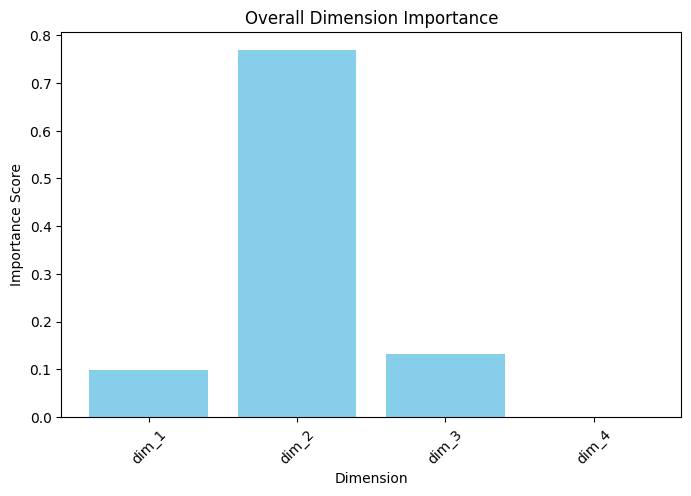

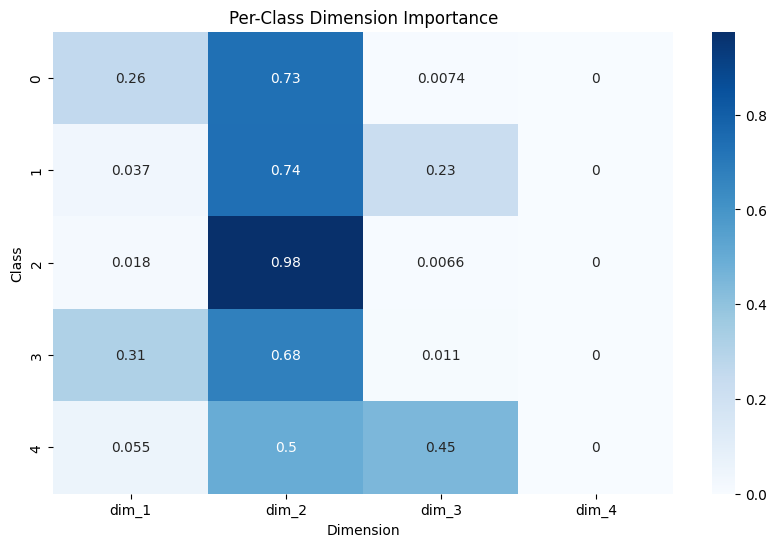

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance_scores(importance_scores, per_class_scores):
    # Overall Dimension Importance (Bar Chart)
    plt.figure(figsize=(8, 5))
    plt.bar(importance_scores.keys(), importance_scores.values(), color='skyblue')
    plt.xlabel("Dimension")
    plt.ylabel("Importance Score")
    plt.title("Overall Dimension Importance")
    plt.xticks(rotation=45)
    plt.show()

    # Per-Class Importance (Heatmap)
    per_class_df = {cls: list(scores.values()) for cls, scores in per_class_scores.items()}
    dim_labels = list(per_class_scores[0].keys())  # Dimension names

    plt.figure(figsize=(10, 6))
    sns.heatmap(list(per_class_df.values()), annot=True, cmap="Blues", xticklabels=dim_labels, yticklabels=list(per_class_df.keys()))
    plt.xlabel("Dimension")
    plt.ylabel("Class")
    plt.title("Per-Class Dimension Importance")
    plt.show()

# Run visualization
plot_importance_scores(perturbation_scores["overall"], perturbation_scores["per_class"])


모든 class에서 예상대로 dim_2가 가장 중요하게 사용되었다.  
또, 예상대로 class0, class3에서는 dim_1이 추가로 중요하게 고려 되었고(이 둘의 차이는 dim_1에서 나타나기 때문)
마찬가지로 class1, class4에서 dim_3가 중요하게 고려 되었다.(이 둘의 차이는 dim_0에서 나타남)